### Libraries and Modules

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, restoration, filters

# Modules
from RICM_VESICLE import RICM, Growth_Area

### Determine the movie details

In [2]:
EXPERIMENT = '20220303_GUV_NTA2_on_SOPC2'    # Experiment name
DATA = 'chamber3_vesicle_1_MMStack_Default'  # Image name
GUV = 3                                      # Vesicle name
dt = 0.538                                   # Actual time interval in seconds

### Read the RICM image for one GUV

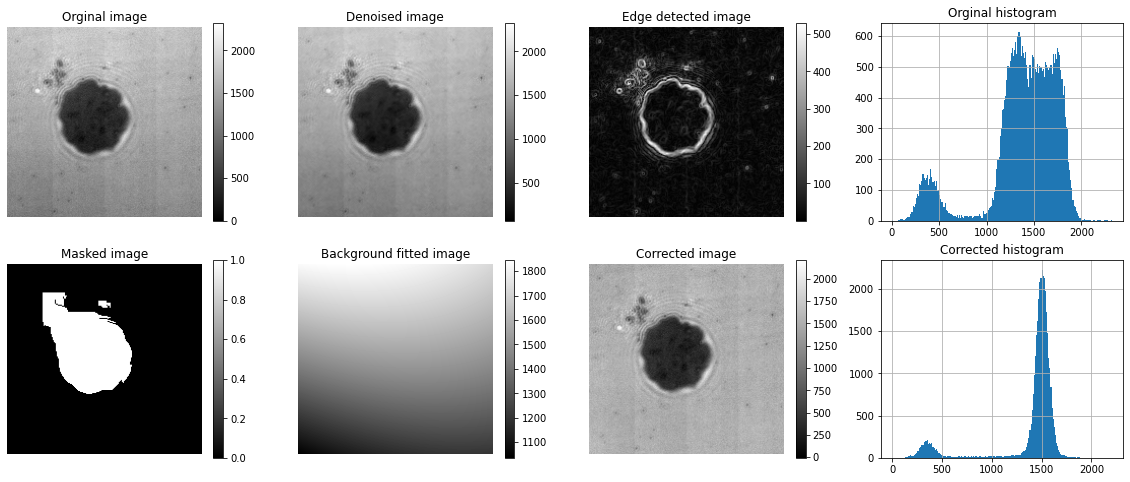

In [3]:
# Read the image
movie_guv = io.imread(f"Data/{EXPERIMENT}/data/{DATA}-{GUV}.tif")[:]

# Subtract the base line
movie_guv = movie_guv - movie_guv[400:450].mean(axis = 0).min()

# Take the average
movie_guv_avg = movie_guv[400:450].mean(axis = 0)

# Define the RICM class with certain n_inner
ricm = RICM(movie_guv_avg, n_inner = 1.344, hole = 2)

# Display the way to the RICM height mapping step by step
ricm.show_summary()

### Measure the area of each frame

In [4]:
%time
# Define the growth area curve
growth = Growth_Area(movie_guv, background=ricm.background_fitting(), denoise=True)
area = growth.area_curve()

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.58 µs


### Plot the growth curve

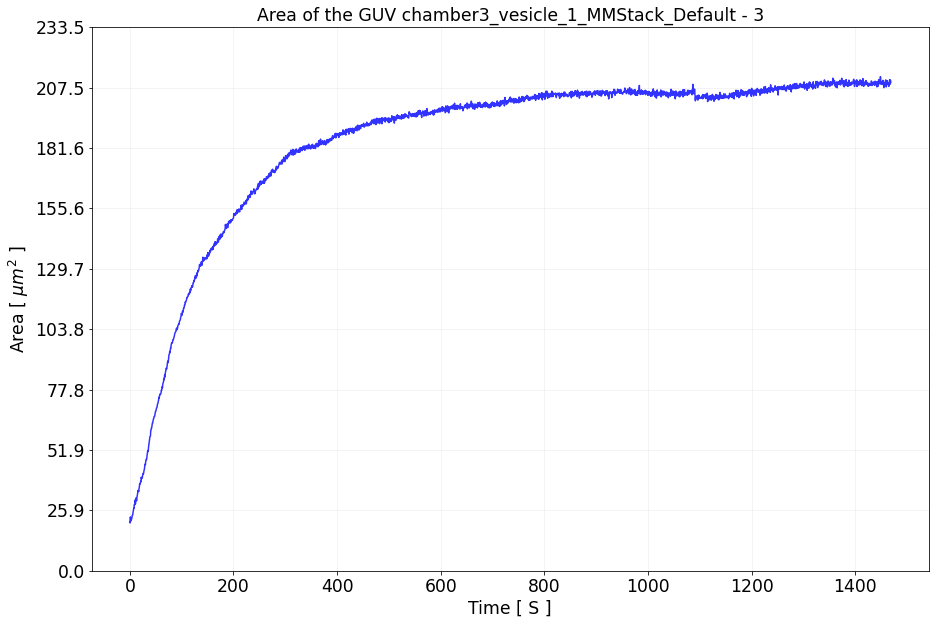

In [5]:
# Define the curve and the time interval
area_curve = area[269:] * 0.16**2
time = np.arange(0, area_curve.shape[0]*dt, dt)

# Define data frame for the scaled time and area
df = pd.DataFrame(data={'Time':time, 'Area':area_curve})

# Plot the curve
plt.figure(figsize=(15, 10))

plt.plot(df['Time'], df['Area'], label = f'{DATA}_{GUV}', color = 'b', alpha = 0.8)

plt.title(f'Area of the GUV {DATA} - {GUV}', fontsize= 'xx-large')
plt.xlabel('Time [ S ]', fontsize = "xx-large")
plt.ylabel('Area [ $\mu m^2$ ]', fontsize = "xx-large")
plt.xticks(fontsize = "xx-large")
plt.yticks(np.linspace(0,area_curve.max() + area_curve.max()/10,10),fontsize = "xx-large")
plt.grid(color = 'gray', alpha = 0.1)

# Save the figure into png
plt.savefig(f"Data/{EXPERIMENT}/results/{DATA}-{GUV}")

# Save the data into csv
df.to_csv(f"Data/{EXPERIMENT}/results/{DATA}-{GUV}.csv", index=False)